In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jijijiji/vocab.txt
/kaggle/input/ddfdffd/52. Less Than 250.csv
/kaggle/input/dliwjrpoef/15. Less Than 250.csv
/kaggle/input/dliwjrpoef/original_cleaned_lemmatized_data (1).csv


In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, tnrange
import os
import re
import json
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from nltk import ngrams
from wordcloud import WordCloud
import warnings
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import spacy
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from gensim.models import Word2Vec
from nltk import ngrams
# from cleantext import clean

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df1=pd.read_csv("/kaggle/input/dliwjrpoef/original_cleaned_lemmatized_data (1).csv")

In [30]:
daily_df1=pd.read_csv("/kaggle/input/ddfdffd/52. Less Than 250.csv")
daily_df1['time'] = pd.to_datetime(daily_df1['time'])

In [31]:
def max_days_month(date_range):
    start_date, end_date = date_range.split(' to ')
    start_month = pd.to_datetime(start_date).month
    end_month = pd.to_datetime(end_date).month
    start_day = pd.to_datetime(start_date).day
    end_day = pd.to_datetime(end_date).day
    
    days_in_start_month = pd.to_datetime(start_date).days_in_month - start_day + 1
    days_in_end_month = end_day
    
    if start_month != end_month:
        days_in_start_month = pd.to_datetime(start_date).days_in_month - start_day + 1
        days_in_end_month = end_day
    else:
        days_in_start_month = pd.to_datetime(end_date).day - start_day + 1
    
    if days_in_start_month > days_in_end_month:
        return start_month
    else:
        return end_month

In [32]:
def max_days_year(date_range):
    start_date, end_date = date_range.split(' to ')
    start_year = pd.to_datetime(start_date).year
    end_year = pd.to_datetime(end_date).year
    start_day = pd.to_datetime(start_date).day
    end_day = pd.to_datetime(end_date).day
    
    days_in_start_year = (pd.to_datetime(start_date) + pd.offsets.YearEnd()).dayofyear - pd.to_datetime(start_date).dayofyear + 1
    days_in_end_year = end_day
    
    if start_year != end_year:
        days_in_start_year = (pd.to_datetime(start_date) + pd.offsets.YearEnd()).dayofyear - pd.to_datetime(start_date).dayofyear + 1
        days_in_end_year = end_day
    else:
        days_in_start_year = pd.to_datetime(end_date).dayofyear - pd.to_datetime(start_date).dayofyear + 1
    
    if days_in_start_year > days_in_end_year:
        return start_year
    else:
        return end_year

In [33]:
df1['time'] = pd.to_datetime(df1['time'])

# Set 'time as the index
df1.set_index('time', inplace=True)

# Resample the DataFrame on a weekly basis, combining texts using 'sum' method
weekly_df1 = df1.resample('W').agg({'text': lambda x: '\n'.join(x),
                                    'tidy_details': lambda x: ' '.join(x),
                                    'tidy_details_no_stop': lambda x: ' '.join(x),
                                    'lem_tidy_details_no_stop': lambda x: ' '.join(x)})
weekly_df1 = weekly_df1[~weekly_df1.apply(lambda row: any(row == ''), axis=1)]

# Reset index to have time as a column again
weekly_df1.reset_index(inplace=True)

# Add a new column containing the range of dates
weekly_df1['date_range'] = (weekly_df1['time'] - pd.DateOffset(days=6)).dt.strftime('%Y-%m-%d') + ' to ' + weekly_df1['time'].dt.strftime('%Y-%m-%d')
weekly_df1['week_no']=weekly_df1.index +1

weekly_df1[['start_date', 'end_date']] = weekly_df1['date_range'].str.split(' to ', expand=True)

# Convert start_date and end_date to datetime
weekly_df1['start_date'] = pd.to_datetime(weekly_df1['start_date'])
weekly_df1['end_date'] = pd.to_datetime(weekly_df1['end_date'])

# Get month from start and end dates
weekly_df1['start_month'] = weekly_df1['start_date'].dt.month
weekly_df1['end_month'] = weekly_df1['end_date'].dt.month

weekly_df1['start_year'] = weekly_df1['start_date'].dt.year
weekly_df1['end_year'] = weekly_df1['end_date'].dt.year


weekly_df1['month'] = weekly_df1.apply(lambda row: row['start_month'] if row['start_month'] == row['end_month']
                                else max(row['start_month'], row['end_month']), axis=1)

weekly_df1['month'] = weekly_df1['date_range'].apply(max_days_month)
weekly_df1['year']=weekly_df1['date_range'].apply(max_days_year)


                       

# Display the DataFrame
print(weekly_df1.head())

KeyError: 'time'

In [ ]:
ind = 0
weekly_df1['day_no_range'] = ""

# Check if 'day_no' is a valid column name in daily_df1
if 'day_no' in daily_df1.columns:
    for index, row in weekly_df1.iterrows():
        start = daily_df1.loc[ind]['day_no']
        ind += 1
        
        while ind < len(daily_df1) and (pd.to_datetime(daily_df1.loc[ind]['date']) <= row['end_date']):
            ind += 1
            if ind == len(daily_df1) - 1:
                break
        
        if ind < len(daily_df1):  # Ensure valid index
            end = daily_df1.loc[ind]['day_no']
            weekly_df1.at[index, 'day_no_range'] = f"{start} to {end-1}"

# Reindex columns in weekly_df1
weekly_df1 = weekly_df1.reindex(columns=['week_no', 'start_date', 'end_date', 'date_range', 'day_no_range', 'text', 'tidy_details', 'tidy_details_no_stop', 'lem_tidy_details_no_stop', 'month', 'year'])


In [34]:
weekly_df1

,index,week_no,start_date,end_date,date_range,day_no_range,text,tidy_details,tidy_details_no_stop,lem_tidy_details_no_stop,...,Upper_score_Aim,growth_sim_score_lower,ideology_sim_score_lower,Lower_score_Aim,growth_sim_score_avg,ideology_sim_score_avg,mean_sim_score_Aim,growth_sim_overlap,ideology_sim_overlap,overlap_sim_Aim
0,0,1,2019-06-17,2019-06-23,2019-06-17 to 2019-06-23,,"To all the dads, grandads, step-dads and fathe...",dads grandads stepdads and father figures than...,dads grandads stepdads father figures thank lo...,dads grandads stepdads father figures thank lo...,...,1,0.980377,0.978874,1,0.990479,0.989448,1,0.0,0.0,NaN
1,1,2,2019-06-24,2019-06-30,2019-06-24 to 2019-06-30,,Worship • Connect • Serve\n\n____\nIt’s what w...,• serveit’s what we do it’s who we are sundays...,• serveit’s it’s sundaysatnewlife worshipconne...,• serveit’s it’s sundaysatnewlife worshipconne...,...,1,0.981053,0.979757,1,0.990481,0.989496,1,0.0,0.0,NaN
2,2,3,2019-07-01,2019-07-07,2019-07-01 to 2019-07-07,,Did you know that New Life is a multi-congrega...,that new life is a multicongregational church ...,new life multicongregational church new life c...,new life multicongregational church new life c...,...,1,0.981053,0.979932,1,0.990410,0.989439,1,0.0,0.0,NaN
3,3,4,2019-07-08,2019-07-14,2019-07-08 to 2019-07-14,,FAMILY ❤️ #SundaysatNewLife @ New Life Church...,new life church the word as we continue throug...,new life church word continue thekingdomislike...,new life church word continue thekingdomislike...,...,1,0.981053,0.979757,1,0.990406,0.989401,1,0.0,0.0,NaN
4,4,5,2019-07-15,2019-07-21,2019-07-15 to 2019-07-21,,“It’s good news to the world that there are pe...,to the world that there are people being conqu...,world people conquered generosity holy spirit”...,world people conquered generosity holy spirit”...,...,1,0.980358,0.978479,1,0.990392,0.989398,1,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,220,221,2023-09-11,2023-09-17,2023-09-11 to 2023-09-17,,We are taking time today to remember those who...,time today to remember those who lost their li...,time today remember lost lives years ago famil...,time today remember lost lives years ago famil...,...,1,0.980657,0.979375,1,0.990434,0.989420,1,0.0,0.0,NaN
221,221,222,2023-09-18,2023-09-24,2023-09-18 to 2023-09-24,,“You’re closer than you think to WINNING!”\n\n...,you think to winning”a word of encouragement t...,think winning”a word encouragement week stand ...,think winning”a word encouragement week stand ...,...,1,0.980387,0.979071,1,0.990500,0.989461,1,0.0,0.0,NaN
222,222,223,2023-09-25,2023-10-01,2023-09-25 to 2023-10-01,,“Do we trust God with…?” \n\nWhat are those fe...,god with…” what are those few things you are s...,god with…” things struggling trust god trust g...,god with…” things struggling trust god trust g...,...,1,0.980387,0.979071,1,0.990495,0.989509,1,0.0,0.0,NaN
223,223,224,2023-10-02,2023-10-08,2023-10-02 to 2023-10-08,,OUTREACH🌎\n\nThank you to everyone who stopped...,everyone who stopped by the outreach booths ye...,everyone stopped outreach booths yesterday fun...,everyone stopped outreach booths yesterday fun...,...,1,0.980358,0.978479,1,0.990445,0.989446,1,0.0,0.0,NaN


In [12]:
pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install transformers


In [14]:
# Import necessary libraries
import torch
from transformers import BertModel, BertTokenizer

# Specify the BERT model and tokenizer you want to use
model_name = 'bert-base-uncased' # This is the smaller version of BERT (uncased)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Example text to encode




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [35]:

    
    
weekly_df1['growth_sim_score'] = 0.0
weekly_df1['ideology_sim_score'] = 0.0
weekly_df1['Upper_score_Aim'] = 'NaN'
    
weekly_df1['growth_sim_score_lower'] = 0.0
weekly_df1['ideology_sim_score_lower'] = 0.0
weekly_df1['Lower_score_Aim'] = 'NaN'
    
weekly_df1['growth_sim_score_avg'] = 0.0
weekly_df1['ideology_sim_score_avg'] = 0.0
weekly_df1['mean_sim_score_Aim'] = 'NaN'
    
weekly_df1['growth_sim_overlap'] = 0.0
weekly_df1['ideology_sim_overlap'] = 0.0
weekly_df1['overlap_sim_Aim']='NaN'
    

    
weekly_df1=weekly_df1.reset_index() 

In [16]:
import os
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling

def preprocess_text_data(csv_file, output_text_file, column_name='text'):
    # Load CSV file
    df = pd.read_csv(csv_file)

    # Extract text data from specified column
    text_data = df[column_name].astype(str).tolist()

    # Write text data to a text file
    with open(output_text_file, 'w', encoding='utf-8') as f:
        for text in text_data:
            f.write(text + '\n')

    print(f"Preprocessed text data saved to: {output_text_file}")

def train_bert_mlm(text_file, output_dir, num_train_epochs=3, per_device_train_batch_size=8, max_seq_length=128):
    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Create directory for output model
    os.makedirs(output_dir, exist_ok=True)

    # Prepare text dataset for MLM training
    dataset = LineByLineTextDataset(
        tokenizer=tokenizer,
        file_path=text_file,
        block_size=max_seq_length,
    )

    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=0.15,  # Probability of masking tokens
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        save_steps=1000,
        logging_steps=1000,
    )

    # Initialize BERT model for masked language modeling
    model = BertForMaskedLM.from_pretrained("bert-base-uncased")

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=dataset,
    )

    # Train the model
    trainer.train()

    # Save the trained model and tokenizer
    model_path = os.path.join(output_dir, "pretrained_model")
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

    print(f"Pretrained model saved to: {model_path}")

# Example usage:
input_csv_file = '/kaggle/input/dliwjrpoef/original_cleaned_lemmatized_data (1).csv'
output_text_file = '/kaggle/working/txtfib'
output_model_dir = '/kaggle/working/fib_model'

# Preprocess text data from CSV file
preprocess_text_data(input_csv_file, output_text_file, column_name='text')

# Train BERT model using MLM on preprocessed text data
train_bert_mlm(output_text_file, output_model_dir)


Preprocessed text data saved to: /kaggle/working/txtfib


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


Pretrained model saved to: /kaggle/working/fib_model/pretrained_model


In [17]:
# import torch
# from transformers import BertModel, BertTokenizer

# # Load the fine-tuned BERT model and tokenizer
# model_path = '/kaggle/working/fib_model/pretrained_model'  # Path to the directory containing the fine-tuned model
# tokenizer = BertTokenizer.from_pretrained(model_path)
# model = BertModel.from_pretrained(model_path)

# # Optionally, move the model to a specific device (e.g., GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Example: Use the fine-tuned BERT model for downstream tasks
# # Replace this with your specific downstream task (e.g., similarity analysis)
# text = "Example sentence for downstream task"
# inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
# inputs.to(device)
# with torch.no_grad():
#     outputs = model(**inputs)
#     embeddings = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token embedding as the representation

# # Now `embeddings` contains the contextualized embedding for the input text
# # You can use these embeddings for tasks like similarity analysis, classification, etc.
# #


In [18]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm  # Import tqdm for progress bar

# Load the text data from a CSV file
text_data = pd.read_csv("/kaggle/input/ddfdffd/52. Less Than 250.csv")["text"].tolist()

# Load the pre-trained BERT model and tokenizer
model_path = '/kaggle/working/fib_model/pretrained_model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)  # Set num_labels=2 for binary classification

# Get the maximum sequence length expected by the pre-trained model
max_model_length = model.config.max_position_embeddings

# Create a dataset and data loader for the unlabeled text data
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=max_model_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return encoding

dataset = TextDataset(text_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Generate pseudo-labels using the pre-trained model
pseudo_labels = []
model.eval()

# Use tqdm to display progress during iteration
for batch in tqdm(dataloader, desc="Pseudo-labeling"):
    with torch.no_grad():
        input_ids = batch['input_ids'].squeeze(1)
        attention_mask = batch['attention_mask'].squeeze(1)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pseudo_labels.extend(torch.argmax(logits, dim=-1).tolist())

# Create a labeled dataset with the pseudo-labels
labeled_dataset = [(text, label) for text, label in zip(text_data, pseudo_labels)]



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/fib_model/pretrained_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss


Training:   0%|          | 0/3 [01:19<?, ?it/s]


ValueError: Trainer: evaluation requires an eval_dataset.

In [20]:
# Tokenize and create a dataset for the pseudo-labeled data
class LabeledDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=max_model_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx])
        }
        return item

train_dataset = LabeledDataset([text for text, _ in labeled_dataset], [label for _, label in labeled_dataset], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Fine-tune the model on the pseudo-labeled data
training_args = TrainingArguments(
    output_dir="/kaggle/working/finetuning",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

from sklearn.model_selection import train_test_split

train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    [text for text, _ in labeled_dataset],
    [label for _, label in labeled_dataset],
    test_size=0.2,  # Use 20% of the data for evaluation
    random_state=42
)

train_dataset = LabeledDataset(train_texts, train_labels, tokenizer)
eval_dataset = LabeledDataset(eval_texts, eval_labels, tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Pass the evaluation dataset
    tokenizer=tokenizer,
)
# Train the model and display progress with tqdm
for epoch in tqdm(range(training_args.num_train_epochs), desc="Training"):
    trainer.train()

# Save the fine-tuned model
trainer.save_model("/kaggle/working/fine-tuned-model")

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000


Training:  33%|███▎      | 1/3 [03:33<07:07, 213.51s/it]

Epoch,Training Loss,Validation Loss
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000


Checkpoint destination directory /kaggle/working/finetuning/checkpoint-40 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/finetuning/checkpoint-80 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/finetuning/checkpoint-120 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Training:  67%|██████▋   | 2/3 [07:09<03:34, 214.80s/it]

Epoch,Training Loss,Validation Loss
1,No log,0.000000
2,No log,0.000000
3,No log,0.000000


Checkpoint destination directory /kaggle/working/finetuning/checkpoint-40 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/finetuning/checkpoint-80 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory /kaggle/working/finetuning/checkpoint-120 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Training: 100%|██████████| 3/3 [10:47<00:00, 215.92s/it]


In [38]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the fine-tuned BERT model and tokenizer
model_path = '/kaggle/working/fib_model/pretrained_model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

# Move the model to CPU or GPU based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define growth and ideology words
growth_words = ['community', 'family', 'congregation', 'join', 'invite', 'reach', 'diversity', 'grow', 'come', 'welcome', 'friendly', 'bring', 'newcomers', 'meet', 'connect', 'volunteers', 'evangelical', 'cultural', 'making_disciples', 'unity', 'missionaries', 'committed_helping', 'christian_fellowship', 'spiritual_growth']
ideology_words = ['devoted', 'parish', 'service', 'tradition', 'gospel', 'liturgy', 'anglican', 'teaching', 'worship', 'glorify_god', 'spiritual', 'open_hearts', 'bible_believing', 'great_commission', 'help', 'inspired_word', 'one_another', 'transformation_world', 'old_new_testament', 'educate']

# Function to tokenize and vectorize words using BERT
def tokenize_and_vectorize_words(word_list):
    word_vectors = []
    for word in word_list:
        tokens = tokenizer.encode(word, add_special_tokens=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(tokens)
            # Use the output of the [CLS] token as the word embedding
            word_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            word_vectors.append(word_embedding.cpu().numpy())
    return np.array(word_vectors)

# Tokenize and vectorize growth and ideology words
growth_vectors = tokenize_and_vectorize_words(growth_words)
ideology_vectors = tokenize_and_vectorize_words(ideology_words)

# Load the vocabulary from a directory in Kaggle
vocab_file_path = '/kaggle/working/fine-tuned-model/vocab.txt'
with open(vocab_file_path, 'r') as file:
    vocab = {line.strip() for line in file}

# Assuming `weekly_df1['text']` contains text data
for index, row in weekly_df1.iterrows():
    detail = weekly_df1['text'][index]  # Get the text data

    # Filter out words not in the vocabulary
    sent = [word for word in detail if word in vocab]

    if len(sent) > 0:
        # Tokenize and vectorize the text data
        word_vectors = tokenize_and_vectorize_words(sent)

        # Reshape word_vectors, growth_vectors, and ideology_vectors if needed
        word_vectors = word_vectors.reshape(len(sent), -1)
        growth_vectors = growth_vectors.reshape(len(growth_words), -1)
        ideology_vectors = ideology_vectors.reshape(len(ideology_words), -1)

        # Compute cosine similarities between word_vectors and growth_vectors/ideology_vectors
        cos_sims_growth = cosine_similarity(word_vectors, growth_vectors)
        cos_sims_ideology = cosine_similarity(word_vectors, ideology_vectors)

        # Compute mean of top 3 cosine similarities
        mean_sim_growth = np.mean(np.sort(cos_sims_growth, axis=1)[:, -3:])
        mean_sim_ideology = np.mean(np.sort(cos_sims_ideology, axis=1)[:, -3:])

        # Update DataFrame with similarity scores
        weekly_df1.at[index, 'growth_sim_score'] = mean_sim_growth
        weekly_df1.at[index, 'ideology_sim_score'] = mean_sim_ideology

        # Compute lower score means for scores > 0.5
#         mean_sim_growth_lower = np.mean(np.sort(cos_sims_growth[cos_sims_growth > 0.5])[:6])
#         mean_sim_ideology_lower = np.mean(np.sort(cos_sims_ideology[cos_sims_ideology > 0.5])[:6])

        filtered_growth_values = cos_sims_growth[cos_sims_growth > 0.5]  # Filter values greater than 0.5
        sorted_growth_values = np.sort(filtered_growth_values)  # Sort filtered values in ascending order
        mean_sim_growth_lower = np.mean(sorted_growth_values[:6])  # Calculate mean of the first six smallest values

# Compute mean of 6 lowest values just greater than 0.5 for cos_sims_ideology
        filtered_ideology_values = cos_sims_ideology[cos_sims_ideology > 0.5]  # Filter values greater than 0.5
        sorted_ideology_values = np.sort(filtered_ideology_values)  # Sort filtered values in ascending order
        mean_sim_ideology_lower = np.mean(sorted_ideology_values[:6]) 

        # Update DataFrame with lower score means
        weekly_df1.at[index, 'growth_sim_score_lower'] = mean_sim_growth_lower
        weekly_df1.at[index, 'ideology_sim_score_lower'] = mean_sim_ideology_lower

        # Compare scores and update 'Upper_score_Aim' and 'Lower_score_Aim'
        weekly_df1.at[index, 'Upper_score_Aim'] = 1 if mean_sim_growth > mean_sim_ideology else 0
        weekly_df1.at[index, 'Lower_score_Aim'] = 1 if mean_sim_growth_lower > mean_sim_ideology_lower else 0

        # Additional checks and updates
        if mean_sim_growth == mean_sim_ideology:
            weekly_df1.at[index, 'Upper_score_Aim'] = -1
        if pd.isna(mean_sim_growth_lower) or pd.isna(mean_sim_ideology_lower) or mean_sim_growth_lower == mean_sim_ideology_lower:
            weekly_df1.at[index, 'Lower_score_Aim'] = -1

        # Compute average similarity scores
        mean_sim_growth_avg = np.mean(cos_sims_growth)
        mean_sim_ideology_avg = np.mean(cos_sims_ideology)

        # Update DataFrame with average similarity scores
        weekly_df1.at[index, 'growth_sim_score_avg'] = mean_sim_growth_avg
        weekly_df1.at[index, 'ideology_sim_score_avg'] = mean_sim_ideology_avg
        weekly_df1.at[index, 'mean_sim_score_Aim'] = 1 if mean_sim_growth_avg > mean_sim_ideology_avg else 0

# Output CSV files after dropping unnecessary columns
output_csv_path_upper = "/kaggle/working/Upper_score_aim_weekly.csv"
output_csv_path_lower = "/kaggle/working/Lower_score_ai_weekly.csv"
output_csv_path_mean = "/kaggle/working/mean_sim_score_aim_weekly.csv"

# Drop specified columns and save to CSV
weekly_df1.drop(['growth_sim_overlap', 'ideology_sim_overlap', 'overlap_sim_Aim',
                 'growth_sim_score_lower', 'ideology_sim_score_lower', 'Lower_score_Aim',
                 'growth_sim_score_avg', 'ideology_sim_score_avg', 'mean_sim_score_Aim'], axis=1) \
          .to_csv(output_csv_path_upper)

weekly_df1.drop(['growth_sim_score', 'ideology_sim_score', 'Upper_score_Aim',
                 'growth_sim_overlap', 'ideology_sim_overlap', 'overlap_sim_Aim',
                 'growth_sim_score_avg', 'ideology_sim_score_avg', 'mean_sim_score_Aim'], axis=1) \
          .to_csv(output_csv_path_lower)

weekly_df1.drop(['growth_sim_score', 'ideology_sim_score', 'Upper_score_Aim',
                 'growth_sim_score_lower', 'ideology_sim_score_lower', 'Lower_score_Aim',
                 'growth_sim_overlap', 'ideology_sim_overlap', 'overlap_sim_Aim'], axis=1) \
          .to_csv(output_csv_path_mean)

Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/fib_model/pretrained_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


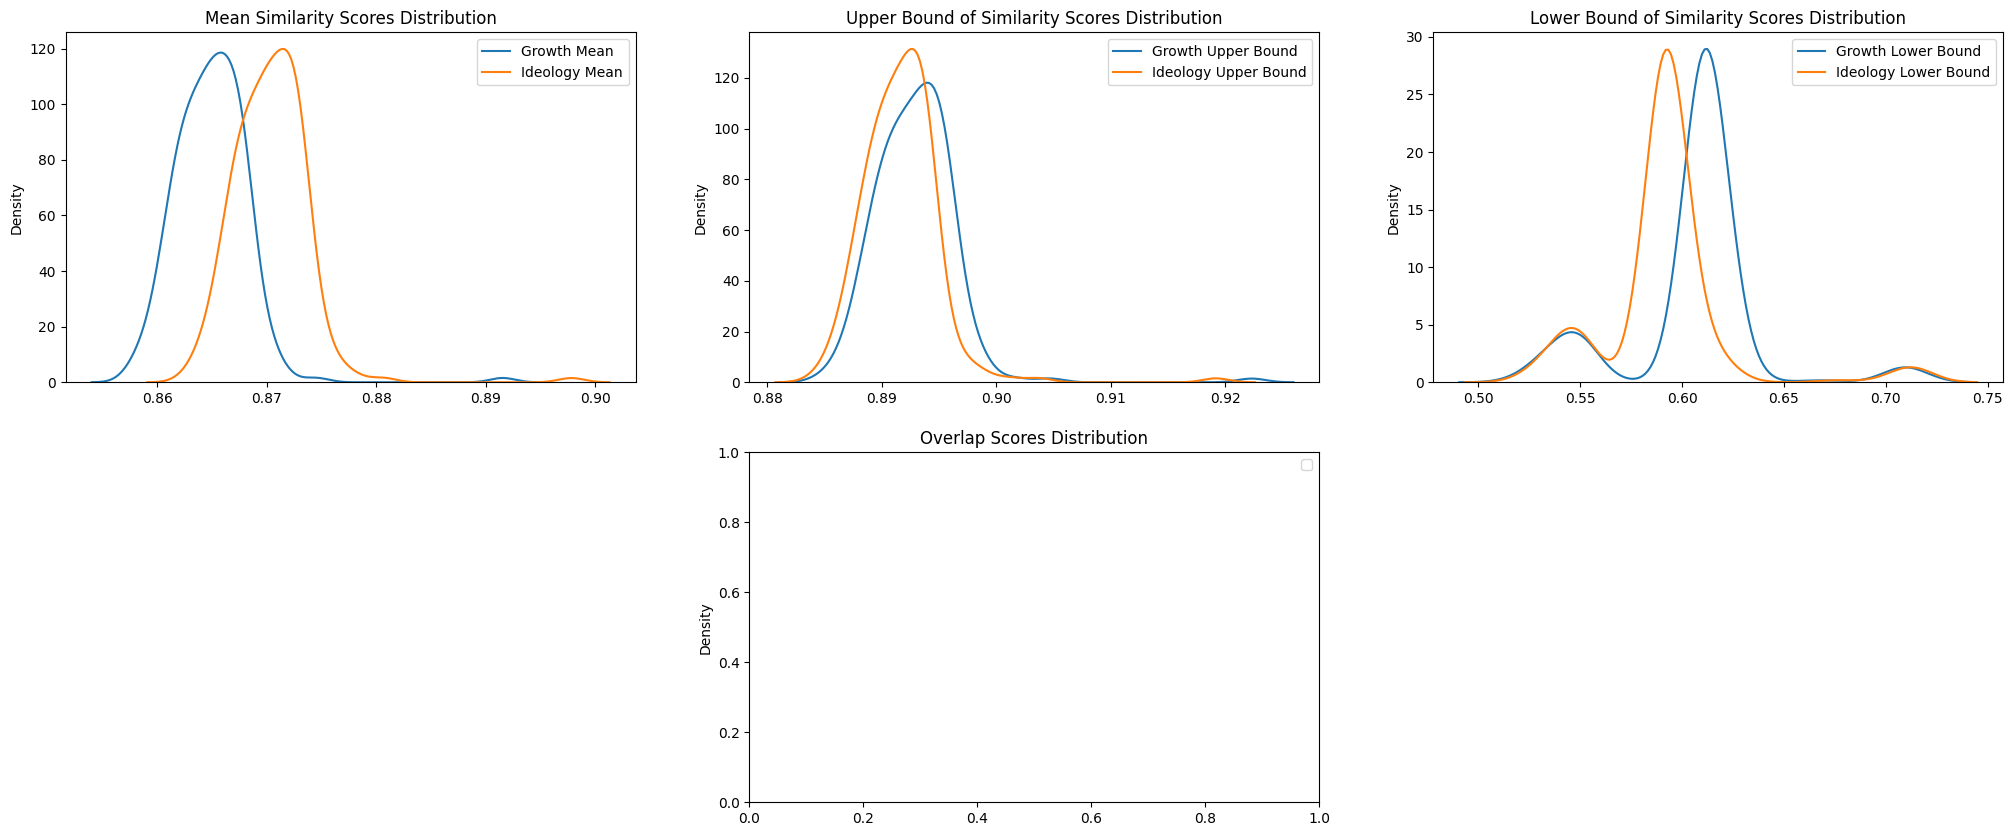

In [40]:
plt.figure(figsize=(25,10))
plt.subplot(231)
plt.title('Mean Similarity Scores Distribution')
sns.kdeplot(weekly_df1['growth_sim_score_avg'].values)
sns.kdeplot(weekly_df1['ideology_sim_score_avg'].values)
plt.legend(['Growth Mean','Ideology Mean'])
plt.subplot(232)
plt.title('Upper Bound of Similarity Scores Distribution')
sns.kdeplot(weekly_df1['growth_sim_score'].values)
sns.kdeplot(weekly_df1['ideology_sim_score'].values)
plt.legend(['Growth Upper Bound','Ideology Upper Bound'])
plt.subplot(233)
plt.title('Lower Bound of Similarity Scores Distribution')
sns.kdeplot(weekly_df1['growth_sim_score_lower'].values)
sns.kdeplot(weekly_df1['ideology_sim_score_lower'].values)
plt.legend(['Growth Lower Bound','Ideology Lower Bound'])
plt.subplot(235)
plt.title('Overlap Scores Distribution')
sns.kdeplot(weekly_df1['growth_sim_overlap'].values)
sns.kdeplot(weekly_df1['ideology_sim_overlap'].values)
plt.legend(['Growth Overlap Score','Ideology Overlap Score'])